In [7]:
import eurostat
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error 
import numpy as np
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose   
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import datetime
import warnings
warnings.simplefilter('ignore')

In [8]:
def mape(true,preds):
    return np.round(np.mean(np.abs(true-preds)/true)*100,2)

# Загрузка данных
Статистические данные с сайта Eurostat можно загрузить посредством API с использованием библиотеки eurostat

In [9]:
toc=eurostat.get_toc_df()

In [10]:
result=eurostat.subset_toc_df(toc, 'Supply, transformation and consumption of gas - monthly data')
result_code = str(result.code.values[0])

In [11]:
df = eurostat.get_data_df(result_code,flags=False)

Для задачи нам нужны только 3 страны: Бельгия, Франция и Испания.

In [12]:
countries_list = ['BE','FR','ES']

In [13]:
target_unit = 'MIO_M3' #нам нужны только объемы - миллионы куб.м.
code_col = r'geo\time' # признак страны
feature='IC_CAL_MG' # необходимый признак

In [14]:
df_sorted=df[(df[code_col].isin(countries_list))&(df['nrg_bal'] == feature)&(df['unit'] == target_unit)]

Предобработка данных

In [15]:
df_t = df_sorted[df_sorted.columns[3:]].set_index(code_col).T
df_t.index=pd.to_datetime(df_t.index,format='%YM%m')
df_t.dropna(inplace=True) # удаляем пустые данные до 2014 года и за июнь-июль 2022 г.
df_t.sort_index(inplace=True)

In [16]:
# Создаем массив с датами для прогноза
date_range=[datetime.datetime(dt.year,dt.month,1) for dt in pd.date_range(start='2022-01', freq='1M', periods=len_forecast)]
future_for_plot=pd.DatetimeIndex(date_range)

### Проверка ряда на стационарность

In [17]:
test_len=3 # длина тестовой выборки
len_forecast=12 # горизонт прогноза

Определение стационарности ряд будем проводить на основе тестовой статистики Дики-Фуллера по p-value. Для упрощения построения прогноза, вместо того, чтобы преобразовывать нестационарный временной ряд, найдем глубину набора данных, на которых ряд будет стационарен.

In [18]:
# тестовая статистика Дики-Фуллера для определения стационарности временного ряда для прогноза
def adfuller_test(df):
    for year in [2019,2018,2017,2016,2015,2014]:
        result=adfuller(df[df.index.year>=year])
        labels = ['Тестовая статистика ADF','p-value','Использованное количество лагов','Количество наблюдений']
        for value,label in zip(result,labels):
            print(label+' : '+str(value) )
        if result[1] <= 0.05:
            print("P-value менее 0.05, поэтому мы можем отвергнуть нулевую гипотезу(Ho). Таким образом, можно заключить, что ряд не имеет единичных корней и является стационарным")
            return year
            break
        else:
            continue
            print("Невозможно отвергнуть нулевую гипотезу, что подтверждает то, что ряд имеет единичные корни и не является стационарным")
            

# Выбор модели прогнозирования

In [19]:
data_depth = {}

Тестовая статистика ADF : -5.540803859071349
p-value : 1.7034422203476106e-06
Использованное количество лагов : 4
Количество наблюдений : 37
P-value менее 0.05, поэтому мы можем отвергнуть нулевую гипотезу(Ho). Таким образом, можно заключить, что ряд не имеет единичных корней и является стационарным


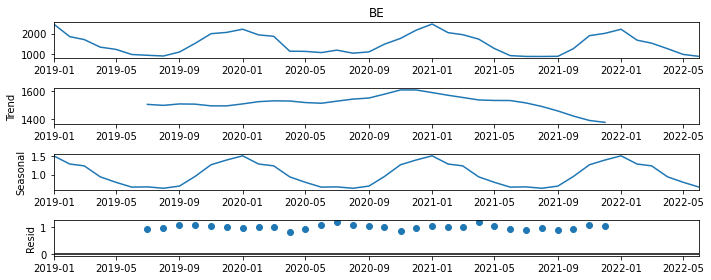

Тестовая статистика ADF : -5.051472502692453
p-value : 1.7535817093108703e-05
Использованное количество лагов : 8
Количество наблюдений : 33
P-value менее 0.05, поэтому мы можем отвергнуть нулевую гипотезу(Ho). Таким образом, можно заключить, что ряд не имеет единичных корней и является стационарным


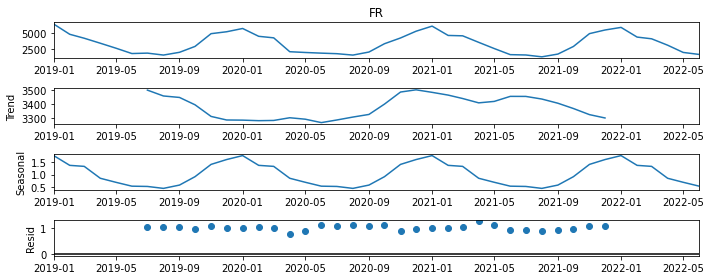

Тестовая статистика ADF : -3.650447039554677
p-value : 0.00486668203906194
Использованное количество лагов : 2
Количество наблюдений : 39
P-value менее 0.05, поэтому мы можем отвергнуть нулевую гипотезу(Ho). Таким образом, можно заключить, что ряд не имеет единичных корней и является стационарным


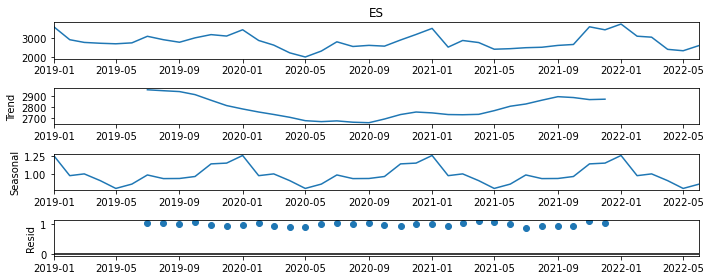

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
for col in countries_list:
    data_depth[col]=adfuller_test(df_t[col])
    decompose_result_mult = seasonal_decompose(df_t[df_t.index.year>=data_depth[col]][col], model="multiplicative")
    fig = decompose_result_mult.plot()
    fig.set_size_inches((10, 4))
    # Tight layout to realign things
    fig.tight_layout()
    plt.show()

In [32]:
data_depth

{'BE': 2019, 'FR': 2019, 'ES': 2019}

In [34]:
# поскольку для всех стран определен 2019 год, ограничим датасет этим годом
df_t = df_t[df_t.index.year>=2019]

## Вывод

Исходя из проведенного анализа, графики потребелния газа всех стран являются стационарными, а также имеют ярко выраженную сезонность.
Как указано на рисунках выше, временной ряд, в общем случае, можно разложить на тренд, сезонность и шум. Стационарный ряд характеризуется тем, что шум, который является случайным, распределен нормально, следовательно, прогноз упрощается тем, что для прогноза необходимо экстраполировать тренд и сезонность, и не нужно искать сложные зависимости в данных для построения модели прогноза значения шума.

Для прогноза рядов с ярко выраженной сезонностью хорошо подходят авторегрессионные модели, например, ARIMA. Также рассмотрены следующие модели:

- Prophet: библиотека, разработанная Facebook, представляющая аддитивную модель с нелинейным трендом. Модель, построенная на основе Prophet, наиболее хорошо подходит для прогнозирования рядов с ярко выраженной сезонностью и глубиной данных в несколько сезонов.
- Модель Хольта-Винтерса: построена на модели экспоненциального сглаживания Хольта и учитывает экспоненциальный тренд и аддитивную сезонность. Данная модель не требует настройки параметров, работает быстро и показывает хорошиие результаты для стационарных временных рядов.

Для выбора наиболее подходящей модели для каждого временного ряда выделим из тренировочной выборки, на которой обучается модель, валидационный набор данных.
Далее по результатам ошибки при сравнении прогноза и валидационной выборки, выберем для каждого ряда свою модель.

### ARIMA

Модель ARIMA характеризуется следующими параметрами:
- p - порядок авторегрессии (AR), который позволяет добавить предыдущие значения временного ряда;
- d - определяет необходимый порядок дифференцированая, ятобы сделать наш ряд стационарным. Поскольку все ряды стационарны, примем этот параметр = 0;
- q - порядок скользящего среднего (MA), который позволяет установить погрешность модели как линейную комбинацию наблюдавшихся ранее значений ошибок.

Для подбора параметров p,q ARIMA построим график автокорреляции (ACF) и график частичной автокорреляции (PACF) на тренировочной выборке (до 2022 года).

BE


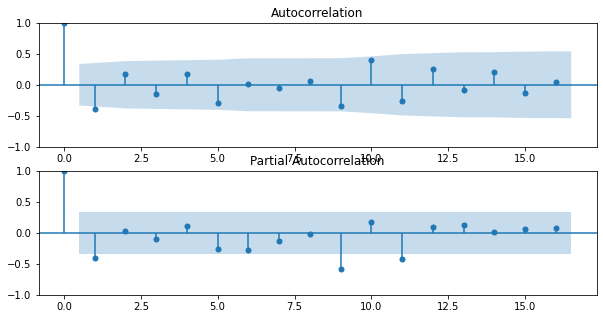

FR


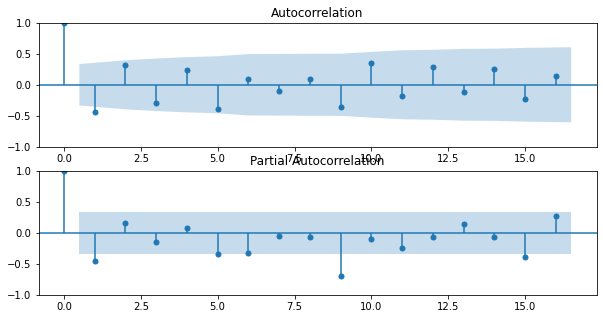

ES


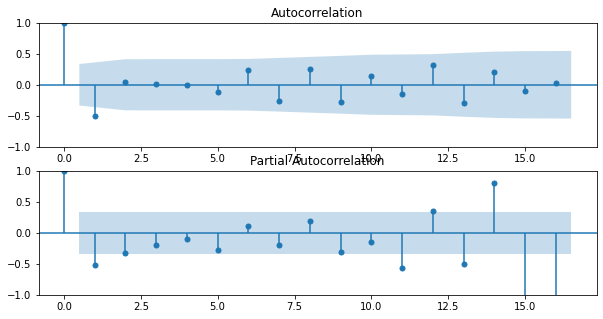

In [60]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
for col in countries_list:
    print(col)
    data_train = df_t[df_t.index.year<2022][col]
    fig, axes = plt.subplots(2, 1, sharex=False,figsize=(10,5))
    plt.title(col)
    plot_acf(data_train.diff().diff().dropna().values, ax=axes[0])
    plot_pacf(data_train.diff().diff().dropna().values, ax=axes[1])
    plt.show()

### Вывод
На графиках PACF для всех рядов первый лаг является наиболее значимым, что говорит о том, что предыдущее значение временного ряда наиболее сильно значимо для текущего значения.
Следовательно p=1. <br><br>
На графиках ACF 2й лаг является последним не отрицательным лагом (выходит за интервал), поэтому пример порядок скользящего среднего q = 2.

### ARIMA

In [124]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def arima_forecast(data_train,data_test):
    model=SARIMAX(data_train,order=(1, 0, 2),seasonal_order=(1,0,2,12)).fit(disp=-1)
    preds=model.predict(len(data_train),len(data_train)+len_forecast-1)
    mse = np.sqrt(mean_squared_error(data_test.values,preds[:len(data_test)]))
    return preds,mse

### Prophet

In [125]:
# FBProphet авторегрессионная модель 
def prophet_forecast(data_train,data_test):
    prophet_df = pd.DataFrame()
    prophet_df['ds']=data_train.index
    prophet_df['y']= data_train.values
    m = Prophet(changepoint_prior_scale=0.01)
    m.fit(prophet_df)
    future = m.make_future_dataframe(periods=len_forecast+1,freq='M')
    forecast = m.predict(future)[['ds','yhat','yhat_lower','yhat_upper']][-len_forecast:]
    mse_prophet=np.sqrt(mean_squared_error(data_test.values,forecast[:len(data_test)]['yhat'].values))
    return forecast['yhat'],mse_prophet

### Экспоненциальное сглаживание Хольта-Винтерса

In [126]:
def hw_forecast(data_train,data_test):
    # модель экспоненциального сглаживания Хольта-Винтерса
    model = ExponentialSmoothing(data_train,trend='mul',seasonal='mul',damped_trend=True, seasonal_periods=12).fit()
    test_predictions = model.forecast(len_forecast)
    mse_hw=np.sqrt(mean_squared_error(data_test.values,test_predictions[:len(data_test)]))

    return test_predictions,mse_hw

### подготовка прогноза

In [127]:
# разделение данных на тестовую и тренировочную выборку
def preprocess_data(col):
    data=pd.DataFrame(df_t[df_t.index.year>=data_depth[col]][col])
    data_train = data[data.index.year<=2021][col]
    #тестовая выборка состоит из первых 3 месяцев 2022 г
    data_test = data[-6:-6+test_len][col]
    return data_train,data_test

# Анализ точности моделей на валидационной выборке. 
Посредством сравнения ошибки на валидационном наборе данных выберем наиболее подходящую модель из двух.



In [131]:
from sklearn.model_selection import train_test_split
from prophet.diagnostics import cross_validation

forecast_dict={}
for col in countries_list:
    data_train,data_test=preprocess_data(col)
    data_train,data_val = train_test_split(data_train,test_size=test_len,shuffle=False)
    preds_prophet,mse_prophet = prophet_forecast(data_train,data_val)
    preds_hw,mse_hw = hw_forecast(data_train,data_val)
    preds_arima,mse_arima = arima_forecast(data_train,data_val)
    # Сравнение моделей
    if mse_hw < mse_prophet and mse_hw <mse_arima:
        preds=preds_hw
        mse=mse_hw
        forecast_dict[col]='HW'
    elif mse_arima < mse_hw and mse_arima <mse_prophet:
        preds=preds_arima
        mse=mse_arima
        forecast_dict[col]='ARIMA'
    else:
        preds=preds_prophet
        mse=mse_prophet
        forecast_dict[col]='Prophet'

00:29:51 - cmdstanpy - INFO - Chain [1] start processing
00:29:51 - cmdstanpy - INFO - Chain [1] done processing
00:29:52 - cmdstanpy - INFO - Chain [1] start processing
00:29:52 - cmdstanpy - INFO - Chain [1] done processing
00:29:53 - cmdstanpy - INFO - Chain [1] start processing
00:29:53 - cmdstanpy - INFO - Chain [1] done processing


In [132]:
forecast_dict

{'BE': 'ARIMA', 'FR': 'HW', 'ES': 'HW'}

BE. Среднеквадратичная ошибка на тесте = 95.0 (5.1%)


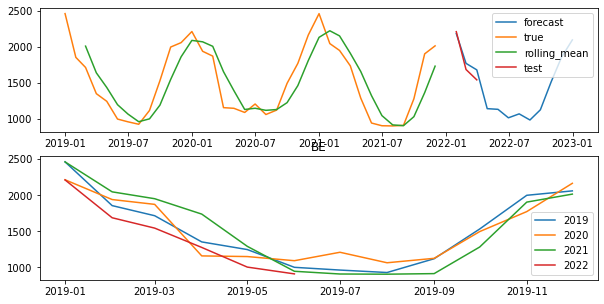

FR. Среднеквадратичная ошибка на тесте = 75.6 (1.5%)


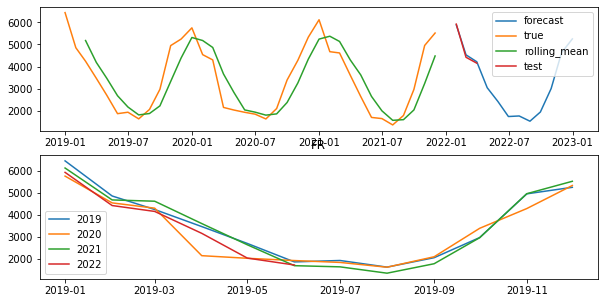

ES. Среднеквадратичная ошибка на тесте = 67.7 (1.6%)


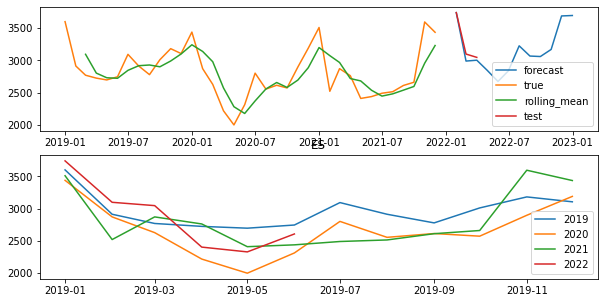

In [142]:
for col in countries_list:
    data_train,data_test=preprocess_data(col)
    data_train=data_train[data_train.index.year>=2018]
    
    # для отображения графика по годам с целью сравнения разобьем датасет по годам
    df=pd.DataFrame(data_train[data_train.index.year==2019])
    df.columns=[2019]
    df['m']=df.index.month
    df_22 = pd.DataFrame(df_t[df_t.index.year==2022][col])
    df_22.columns=[2022]
    df_22['m']=df_22.index.month
    df[2020] = data_train[data_train.index.year==2020].values
    df[2021] = data_train[data_train.index.year==2021].values
    df=df.merge(df_22,left_on=['m'],right_on=['m'],how='outer')
    df.drop(columns='m',inplace=True)
    df['DT']=data_train[data_train.index.year==2019].index
    
    
    # создание массива с датами для прогноза
    future =pd.date_range(start='2022-01-31',freq='1M',periods=12)

    forecast_model = forecast_dict[col]
    
    if forecast_model == 'HW':
        preds,mse = hw_forecast(data_train,data_test)
    elif forecast_model == 'Prophet':
        preds,mse = prophet_forecast(data_train,data_test)
    else: preds,mse = arima_forecast(data_train,data_test)
    
    data_train = pd.DataFrame(data_train)
    # вычислим скользящее среднее по 3 месяцам
    data_train['rolling_mean'] = data_train.rolling(3).mean()
    
    fig, axes = plt.subplots(2, 1, sharex=False,figsize=(10,5))
    plt.title(col)
    print('{}. Среднеквадратичная ошибка на тесте = {:.1f} ({:.1f}%)'.format(col,mse, mape(data_test.values,preds[:test_len])))
    axes[0].plot(future[-12:].values,preds.values,label='forecast')
    axes[0].plot(data_train.index,data_train[col],label='true')
    axes[0].plot(data_train.index,data_train['rolling_mean'],label='rolling_mean')
    axes[0].plot(future[-12:-12+test_len].values,data_test.values,label='test')
    axes[0].legend()
    
    axes[1].plot(df.set_index('DT'))
    axes[1].legend(labels=df.columns)
    plt.show()

## Вывод

Для оценки результатов прогноза была использована в качестве метрики среднеквадратичная ошибка, так как она позволяет идентифицировать значительные отклонения прогноза от факта ввиду возведения ошибки в квадрат.
Применение среднеквадратичной ошибки является стандартом при прогнозирования многих параметров, например, электропотребления.

Выполнен анализ временных рядов потребления газа в европейских странах, в результате чего установлено, что данные ряды является стационарными с ярко выраженной сезонностью в течение года.
Данная сезонность, в первую очередь, связана с отопительным сезоном, так как основную тепловую нагрузку несут ТЭС, работающие на газовом топливе.

Выполнен подбор параметров модели ARIMA по функции автокорреляции и частичной автокорреляции.

По результатам прогноза удалось добиться ошибки:
- Бельгия: 95 млн.куб.м (5.1%) при использовании модели ARIMA;
- Франция: 75.6 млн.куб.м (1.5%) при использовании модели Хольта-Винтерса;
- Испания: 67.7 млн.куб.м (1.6%) при использовании модели Хольта-Винтерса.